In [1]:
#from environment import * 
import numpy as np 
import matplotlib.pyplot as plt 
import re

In [2]:
first_time="6:30"
last_time="22:00"
max_capacity = 47
trf_path="data/line3/traffic-1.csv"
passenger_info_path = "data/line3/passenger_dataframe_direction1.csv"
trf_con = pd.DataFrame(pd.read_csv(trf_path))
first_minute_th = (int(first_time[:-3]) - int(trf_con.iloc[0, 0])) * 60 + (int(first_time[-2:]) - int(trf_con.iloc[0, 1]))
last_minute_th = (int(last_time[:-3]) - int(trf_con.iloc[0, 0])) * 60 + (int(last_time[-2:]) - int(trf_con.iloc[0, 1]))
current_minute_th = first_minute_th
passenger_columns = ['Label', 'Boarding time', 'Boarding station', 'Alighting station','Arrival time']
bus_image = mpimg.imread('busImage.png')
rewards = []

(<Figure size 1700x500 with 1 Axes>, <Axes: >)

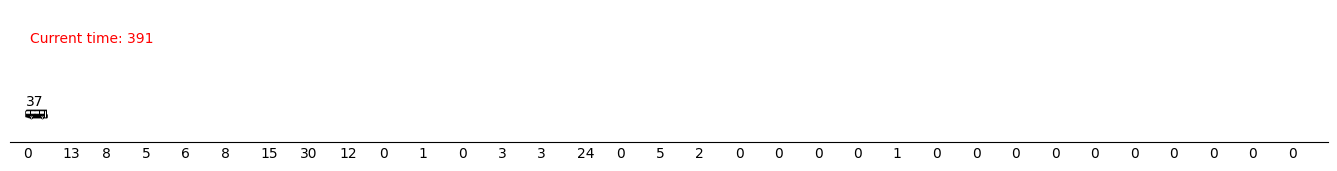

In [5]:
Line = BusLine(passenger_info_path,trf_path,first_minute_th,last_minute_th,max_capacity,1)
reward,new_state = Line.update_environment(1)
Line.plot()

In [8]:
import os
import cv2

def save_frames_as_video(frames_path, output_video_path, frame_rate=24):
    # Get the list of filenames and sort them numerically
    filenames = sorted(os.listdir(frames_path), key=lambda x: int(x.split('.')[0]))
    frame = cv2.imread(os.path.join(frames_path, filenames[0]))
    height, width, layers = frame.shape
    video = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), frame_rate, (width,height))

    for filename in filenames:
        if filename.endswith('.png'):  # Adjust this if your frames are saved with a different extension
            img = cv2.imread(os.path.join(frames_path, filename))
            video.write(img)

    cv2.destroyAllWindows()
    video.release()

# Example usage
frames_path = 'plots'  # Change this to the folder containing your frames
output_video_path = 'output.mp4'  # Change this to the desired output video file path
frame_rate = 5  # Change this to adjust the frame rate

# Call the function to create the video
save_frames_as_video(frames_path, output_video_path, frame_rate)
